In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
try:
    import empyrical as emp
except:
    emp = None
import tushare as ts
import time
import random
import itertools
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq
from spider.spider_coinmarketcap import Spider_coinmarketcap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
CRYPTOCURRENCY = list(CRYPTOCURRENCY.keys())
NASDAQ100 = CONF['NASDAQ100']
HS300 = list(ts.get_hs300s()['code'])

BENCHMARK = '399300'
# TARGET = ['399300']
TARGET = HS300
# BENCHMARK = 'NDX'
# TARGET = NASDAQ100
# BENCHMARK = 'BITCOIN'
# TARGET = CRYPTOCURRENCY
# BENCHMARK = 'EOS'
# TARGET = ['EOS']

ALL_TARGET = TARGET[:]

pd

<module 'pandas' from 'd:\\python3\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

IS_DOWNLOAD_DATA = False
spider_n = Spider_nasdaq()
spider_c = Spider_coinmarketcap()
timeframe = '10y'
ignore = True

for symbol in TARGET + [BENCHMARK]:
    if not IS_DOWNLOAD_DATA:
        break

    # 沪深300指数
    if symbol == '399300':
        df = ts.get_k_data(code=symbol, index=True, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # A股
    elif symbol in HS300:
        df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # NASDAQ
    elif symbol in NASDAQ100:
        datafile = None
        while datafile is None:
            try:
                datafile = spider_n.get_stock_data(symbol, timeframe)
            except:
                time.sleep(5)
    
    # CRYPTOCURRENCY
    elif symbol in CRYPTOCURRENCY:
        datafile = spider_c.get_coin_data(symbol, start_date='20100101', end_date=time.strftime('%Y%m%d'))
        
    print(datafile)
    time.sleep(1)

Wall time: 0 ns


In [3]:
%%time

### 时间设置
start_date = '2014-01-01'
end_date = '2018-08-01'

TURTLE_POS = 50
### Turtle System One - Short
TURTLE_SHORT_BUY_N = 20
TURTLE_SHORT_SELL_N = 20
### Turtle System Two - Long
TURTLE_LONG_BUY_N = 60
TURTLE_LONG_SELL_N = 60

### 业务设置
IS_HAPPYMONEY = False
IS_TAX = False
IS_SLIPPAGE = False
IS_RANDOM_BUY = False
IS_FILTER = False
IS_MARKETUP = True
IS_BUYBENCHMARK = True
IS_SHOWBUYLIST = True
START_MONEY = 100000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY


Wall time: 0 ns


In [4]:
%%time

def get_stock_df_dict(TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N):
    stock_df_dict = {}
    for symbol in TARGET + [BENCHMARK]:
        stock_data_file = '../database/market/%s.csv' % symbol
        stock_df = pd.read_csv(stock_data_file)

        # 筛选字段
        stock_df = stock_df.loc[:, ['date', 'open', 'close']]

        # 去掉Nasdaq行情首行的当天行情
        if symbol in NASDAQ100:
            stock_df = stock_df.drop([0])

        # 抛弃空值异常值
        stock_df.dropna(axis=0, how='any', inplace=True)

        # 格式化日期
        stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

        # 用日期作索引，日期升序排序
        if symbol in NASDAQ100 or symbol in CRYPTOCURRENCY:
            stock_df = stock_df[::-1]
        stock_df.set_index(['date'], inplace=True)
        stock_df.index = stock_df.index.to_period('D')

        # 计算每天涨跌幅
        stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
        stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.close.shift(1)) / stock_df.close.shift(1)

        # Turtle指标
        stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
        stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
        stock_df['MA180'] = stock_df['open'].rolling(180).mean()
        stock_df['MA60'] = stock_df['open'].rolling(60).mean()
        stock_df['MA30'] = stock_df['open'].rolling(30).mean()

        # 减少数据
        stock_df.dropna(how='any', inplace=True)

        stock_df_dict[symbol] = stock_df
        
    return stock_df_dict

Wall time: 0 ns


In [5]:
%%time
# %xmode

def run_turtle(symbol_list, stock_df_dict, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N):
    PROPERTY = START_MONEY
    CASH = START_MONEY
    count_day = 0
    yesterday = None
    miss_buy_short = 0
    miss_buy_long = 0
    
    '''用基准数据来存储策略数据'''
    show_df = None
    show_df = stock_df_dict[BENCHMARK].copy()
    show_df.loc[:, 'CASH_TURTLE'] = START_MONEY
    show_df.loc[:, 'PROPERTY_TURTLE'] = START_MONEY

    order_df = None
    order_df = pd.DataFrame(columns=[
        'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
    ])

    ops_df = None
    ops_df = pd.DataFrame(columns=[
        'ops_date', 'ops', 'symbol', 'count', 'price', 'reason', 'profit'
    ])


    # 时间序列
    for today in pd.period_range(start=start_date, end=end_date, freq='D'):
        count_day += 1

        # 每年年初计算回报率
        if today.dayofyear == 1 or today == (pd.to_datetime(end_date)).to_period(freq='D'):
            print(today, time.ctime())
    #         if today.dayofyear == 1:
    #             lastyear_firstday = pd.to_datetime('%d-01-01' % (today.year - 1))
    #         else:
    #             lastyear_firstday = pd.to_datetime('%d-01-01' % today.year)
    #         lastyear_firstday = lastyear_firstday.to_period(freq='D')
    # #         print(today, show_df.iloc[0].name, show_df[:today].iloc[-1].PROPERTY_TURTLE)
    #         if today > show_df.iloc[0].name:
    #             today_property = show_df[:today].iloc[-2].PROPERTY_TURTLE
    # #             print(show_df[:today].iloc[-1])
    #         else:
    #             today_property = show_df.iloc[0].PROPERTY_TURTLE
    #         if lastyear_firstday > show_df.iloc[0].name:
    #             lastyear_firstday_property = show_df[:lastyear_firstday].iloc[-1].PROPERTY_TURTLE
    #         else:
    #             lastyear_firstday_property = show_df.iloc[0].PROPERTY_TURTLE
    # #         lastyear_return = round((today_property - lastyear_firstday_property) / lastyear_firstday_property, 4)
    #         lastyear_return = '%.3f' % ((today_property - lastyear_firstday_property) / lastyear_firstday_property)
    #         print(lastyear_firstday, today, int(lastyear_firstday_property), int(today_property), lastyear_return)
    
        # 每年筛股
        if IS_FILTER and (today.dayofyear == 1 or count_day == 1):
            TARGET = ALL_TARGET[:]
            benchmark_lastyear = stock_df_dict[BENCHMARK][:today]

            # 不到一年（250个交易日）
            if len(benchmark_lastyear) < 250:
                continue

            # 筛选过滤
            benchmark_return_lastyear = benchmark_lastyear.iloc[-1].open / benchmark_lastyear.iloc[-250].open
            for symbol, stock_df in stock_df_dict.items():
                try:
                    return_lastyear = stock_df[:today].iloc[-1].open / stock_df[:today].iloc[-250].open
                    if return_lastyear < benchmark_return_lastyear:
                        TARGET.remove(symbol)
    #                     print(symbol, return_lastyear)
                except:
                    TARGET.remove(symbol)
                    pass
            print(today, 'TARGET after filter', len(TARGET))


        if yesterday is None:
            yesterday = today
            continue

        # 日期不在基准交易日，则不交易
        if today not in stock_df_dict[BENCHMARK].index:
            continue

        # 突破下行趋势，清仓退出
        order_arr = order_df.to_records(index=False)
        if len(order_arr[(order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
            is_sell = False
            for idx in order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)].index:
                cur_order = order_df.loc[idx]
                symbol = cur_order['symbol']
                if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
                    continue
                today_market = stock_df_dict[symbol].loc[today]
                if today_market.c_o_pct_chg < -0.1 and symbol in HS300:
    #                 print(today, symbol, '跌停板，卖不掉')
                    continue
                if cur_order.buy_reason == 'SHORT':
                    is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N])
                if cur_order.buy_reason == 'LONG':
                    is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N])
                if is_sell:
                    CASH += cur_order.buy_count * today_market.open
                    order_df.loc[idx, 'sell_date'] = today
                    order_df.loc[idx, 'sell_price'] = today_market.open
                    order_df.loc[idx, 'sell_reason'] = 'EXIT'
                    order_df.loc[idx, 'profit'] = \
                        (today_market.open - cur_order.buy_price) * cur_order.buy_count
    #                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)

                    ops_df = ops_df.append(
                        {
                            'ops_date': today,
                            'ops': 'SELL',
                            'symbol': symbol,
                            'count': cur_order.buy_count,
                            'price': today_market.open,
                            'reason': cur_order.buy_reason,
                            'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
                        },
                        ignore_index=True
                    )

        # 开心止盈，倍数止盈
        if IS_HAPPYMONEY:        
            if PROPERTY > START_MONEY * 2 and CASH > START_MONEY:
                HAPPY_MONEY += START_MONEY
                PROPERTY -= START_MONEY
                CASH -= START_MONEY

        benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
        try:
            benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-2]
        except:
            benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-1]
        buy_list = []

        # 遍历标的，判断和执行买入
        for symbol in symbol_list:

            # 趋势交易，只在好行情时买入
            if IS_MARKETUP:
                if benchmark_today_market.MA60 < benchmark_today_market.MA180:
    #             if benchmark_yesterday_market.MA60 < benchmark_yesterday_market.MA180:
                    break

            # 是否购买基准
            if not IS_BUYBENCHMARK and symbol == BENCHMARK:
                continue

            if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
                continue

            # TIME TEST
            # DELETED

            today_market = stock_df_dict[symbol].loc[today]

            # 突破上行趋势，就买一份
            order_arr = order_df.to_records(index=False)
            is_buy = False
            # 指数就不要过滤器了
            if True:
                if today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N]:
                    is_buy = True
                    buy_reason = 'LONG'
                elif False and today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N]:
                    is_buy = True
                    buy_reason = 'SHORT'

            if is_buy:
                buy_list.append(symbol)

        if IS_RANDOM_BUY:
            random.shuffle(buy_list)
        else:
            tmp_list = []
            for symbol in buy_list:
                try:
                    return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[-250].open
                except:
                    return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[1].open
                tmp_list.append((return_lastyear, symbol))
            tmp_list = sorted(tmp_list, reverse=True)
            buy_list = [x[1] for x in tmp_list if x[0]>1]
    #         buy_list = [x[1] for x in tmp_list]

        for symbol in buy_list:
            today_market = stock_df_dict[symbol].loc[today]
            buy_count = 0

            # 滑点
            if IS_SLIPPAGE:
                buy_price = today_market.open * (1 + random.randint(0, 20) / 1000)
            else:
                buy_price = today_market.open

            # 按份数买
            if CASH >= PROPERTY / TURTLE_POS:
                buy_count = int((PROPERTY / TURTLE_POS) / buy_price)

            # 指数购买，满仓干
    #         buy_count = int(CASH / buy_price)

            if buy_count > 0:
                if today_market.c_o_pct_chg > 0.1 and symbol in HS300:
    #                 print(today, symbol, '涨停板，买不进')
                    continue

            if buy_count > 0:
                CASH -= buy_count * buy_price
    #             print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
                order_df = order_df.append(
                    {
                        'buy_date': today,
                        'symbol': symbol,
                        'buy_count': buy_count,
                        'buy_price': today_market.open,
                        'buy_reason': buy_reason,
                        'sell_date': pd.np.nan,
                        'sell_price': 0,
                        'profit': 0,
                        'cash': CASH,
                        'property': PROPERTY,
                    },
                    ignore_index=True
                )
                ops_df = ops_df.append(
                    {
                        'ops_date': today,
                        'ops': 'BUY',
                        'symbol': symbol,
                        'count': buy_count,
                        'price': buy_price,
                        'reason': buy_reason,
                        'profit': 0,
                    },
                    ignore_index=True
                )
            else:
                if buy_reason == 'LONG':
                    miss_buy_long += 1
                elif buy_reason == 'SHORT':
                    miss_buy_short += 1

        # 每天盘点财产
        # 大盘下行时，闲钱进行T+0无风险投资，如货币基金
        if benchmark_today_market.MA60 < benchmark_today_market.MA180:
            CASH = CASH * (1 + 0.03 / 365)
        show_df.loc[today, 'CASH_TURTLE'] = CASH
        PROPERTY = CASH + \
            sum(
                [
                    stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
                    for idx in order_df.loc[order_df['sell_price']==0].index
                ]
            )
        show_df.loc[today, 'PROPERTY_TURTLE'] = PROPERTY

        yesterday = today



    # 最后一天，清仓
    order_arr = order_df.to_records(index=False)
    for idx in order_df[order_df['sell_price'] == 0].index:
        cur_order = order_df.loc[idx]
        symbol = cur_order['symbol']
        today_market = stock_df_dict[symbol][:today].iloc[-1]
        CASH += cur_order.buy_count * today_market.open
        order_df.loc[idx, 'sell_date'] = today
        order_df.loc[idx, 'sell_price'] = today_market.open
        order_df.loc[idx, 'sell_reason'] = 'EXIT'
        order_df.loc[idx, 'profit'] = \
            (today_market.open - cur_order.buy_price) * cur_order.buy_count
        ops_df = ops_df.append(
            {
                'ops_date': today,
                'ops': 'SELL',
                'symbol': symbol,
                'count': cur_order.buy_count,
                'price': today_market.open,
                'reason': cur_order.buy_reason,
                'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
            },
            ignore_index=True
        )


#     print('START_MONEY', START_MONEY)
#     print('CASH', CASH)
#     print('HAPPY_MONEY', HAPPY_MONEY)
#     print('PROPERTY', PROPERTY)

#     s_p = stock_df_dict[BENCHMARK][start_date:].iloc[0].open
#     e_p = stock_df_dict[BENCHMARK][:end_date].iloc[-1].open
#     print('BENCHMARK', s_p, e_p, e_p / s_p)
    return show_df, order_df, PROPERTY, miss_buy_long


Wall time: 0 ns


In [6]:
score_df = None
score_df = pd.DataFrame(columns=[
    'START',
    'END',
    'TURTLE_POS',
    'ROLLMAX',
    'ROLLMIN', 
    'MA_SHORT', 
    'MA_LONG', 
    'X_DAY_RETURN', 
    'ORDER',
    'STOCK',
    'RETURN',
    'MAXDROPDOWN',
    'WINRATE',
    'annual_return',
    'annual_volatility',
    'calmar_ratio',
    'sharpe_ratio',
    'alpha',
    'beta',
    'ALL_DAYS',
    'FREECASH_DAY',
    'MISS_SIGNAL',
    'RET_PER_YEAR',
])

In [20]:
TURTLE_POS = 10
TURTLE_LONG_BUY_N = 60
TURTLE_LONG_SELL_N = 60

# for i in range(6, 19, 1):
# for i in range(11, 14, 1):
for i in range(20, 81, 1):
    time.ctime()
    print(i)
#     global TURTLE_POS
#     TURTLE_POS = i
    TURTLE_LONG_BUY_N = i
    TURTLE_LONG_SELL_N = i

    stock_df_dict = None
    show_df = None
    order_df = None
    PROPERTY = None
    symbol_list = TARGET + [BENCHMARK]

    stock_df_dict = get_stock_df_dict(TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)
    show_df, order_df, PROPERTY, miss_buy_long = run_turtle(symbol_list, stock_df_dict, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)

    df = show_df.dropna(how='any', inplace=False).copy()
    df = df.loc[start_date:end_date]
    algo = df['PROPERTY_TURTLE'].pct_change()
    benchmark = df.open.pct_change()

#     if emp:
#         'cum_returns', emp.cum_returns(algo)[-1], emp.cum_returns(benchmark)[-1]
#         'max_drawdown', emp.max_drawdown(algo), emp.max_drawdown(benchmark)
#         'annual_return', emp.annual_return(algo), emp.annual_return(benchmark)
#         'annual_volatility', emp.annual_volatility(algo, period='daily')
#         'calmar_ratio', emp.calmar_ratio(algo)
#         'sharpe_ratio', emp.sharpe_ratio(returns=algo)
#         'alpha', emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00)
#         'beta', emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00)

    ALL_DAYS = len(df)
    FREECASH_DAY = len(df[df['CASH_TURTLE'] > (df['PROPERTY_TURTLE'] / TURTLE_POS)])


    output_str = ''
    for y in range(int(start_date.split('-')[0]), int(end_date.split('-')[0])+1, 1):
        y_df = df.loc['%d-01-01' % y:'%d-01-01' % (y+1)]
        y_algo = y_df['PROPERTY_TURTLE'].pct_change()
        y_benchmark = y_df.open.pct_change()
        result = '%d-%d,%.3f,%.3f,%.3f,%.3f' % (
            y, y+1, emp.cum_returns(y_algo)[-1], emp.cum_returns(y_benchmark)[-1], emp.max_drawdown(y_algo), emp.max_drawdown(y_benchmark)
        )
#         result
        output_str += result
        output_str += ';'
#     output_str

    df = order_df.copy()
    df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
    df = df.loc[:, ['symbol', 'pro_pct']]
    df = df.groupby(by='symbol').sum()
    buy_stock_count = len(df)
#     buy_stock_count
    
    score_df = score_df.append({
        'START': start_date,
        'END': end_date,
        'TURTLE_POS': TURTLE_POS,
        'ROLLMAX': TURTLE_LONG_BUY_N,
        'ROLLMIN': TURTLE_LONG_SELL_N, 
        'MA_SHORT': 60, 
        'MA_LONG': 180, 
        'X_DAY_RETURN': 250, 
        'ORDER': len(order_df),
        'STOCK': buy_stock_count,
        'RETURN': emp.cum_returns(algo)[-1],
        'MAXDROPDOWN': emp.max_drawdown(algo),
        'WINRATE': len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0]),
        'annual_return': emp.annual_return(algo),
        'annual_volatility': emp.annual_volatility(algo, period='daily'),
        'calmar_ratio': emp.calmar_ratio(algo),
        'sharpe_ratio': emp.sharpe_ratio(returns=algo),
        'alpha': emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'beta': emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'ALL_DAYS': ALL_DAYS,
        'FREECASH_DAY': FREECASH_DAY,
        'MISS_SIGNAL': miss_buy_long,
        'RET_PER_YEAR': output_str,
    }, ignore_index = True)

score_df
score_df.to_csv('../database/%s.csv' % time.strftime('%Y-%m-%d-%H-%M-%S'))

'Thu Sep 13 09:19:07 2018'

20
2014-01-01 Thu Sep 13 09:19:19 2018
2015-01-01 Thu Sep 13 09:19:37 2018
2016-01-01 Thu Sep 13 09:20:16 2018
2017-01-01 Thu Sep 13 09:20:37 2018
2018-01-01 Thu Sep 13 09:21:55 2018
2018-08-01 Thu Sep 13 09:22:16 2018


'Thu Sep 13 09:22:17 2018'

21
2014-01-01 Thu Sep 13 09:22:24 2018
2015-01-01 Thu Sep 13 09:22:41 2018
2016-01-01 Thu Sep 13 09:23:14 2018
2017-01-01 Thu Sep 13 09:23:32 2018
2018-01-01 Thu Sep 13 09:24:36 2018
2018-08-01 Thu Sep 13 09:25:01 2018


'Thu Sep 13 09:25:02 2018'

22
2014-01-01 Thu Sep 13 09:25:13 2018
2015-01-01 Thu Sep 13 09:25:35 2018
2016-01-01 Thu Sep 13 09:26:19 2018
2017-01-01 Thu Sep 13 09:26:50 2018
2018-01-01 Thu Sep 13 09:28:06 2018
2018-08-01 Thu Sep 13 09:28:29 2018


'Thu Sep 13 09:28:29 2018'

23
2014-01-01 Thu Sep 13 09:28:52 2018
2015-01-01 Thu Sep 13 09:29:11 2018
2016-01-01 Thu Sep 13 09:29:48 2018
2017-01-01 Thu Sep 13 09:30:07 2018
2018-01-01 Thu Sep 13 09:31:15 2018
2018-08-01 Thu Sep 13 09:31:38 2018


'Thu Sep 13 09:31:38 2018'

24
2014-01-01 Thu Sep 13 09:31:45 2018
2015-01-01 Thu Sep 13 09:32:04 2018
2016-01-01 Thu Sep 13 09:32:40 2018
2017-01-01 Thu Sep 13 09:32:58 2018
2018-01-01 Thu Sep 13 09:34:00 2018
2018-08-01 Thu Sep 13 09:34:22 2018


'Thu Sep 13 09:34:22 2018'

25
2014-01-01 Thu Sep 13 09:34:29 2018
2015-01-01 Thu Sep 13 09:34:48 2018
2016-01-01 Thu Sep 13 09:35:22 2018
2017-01-01 Thu Sep 13 09:35:41 2018
2018-01-01 Thu Sep 13 09:36:42 2018
2018-08-01 Thu Sep 13 09:37:03 2018


'Thu Sep 13 09:37:03 2018'

26
2014-01-01 Thu Sep 13 09:37:10 2018
2015-01-01 Thu Sep 13 09:37:27 2018
2016-01-01 Thu Sep 13 09:38:01 2018
2017-01-01 Thu Sep 13 09:38:20 2018
2018-01-01 Thu Sep 13 09:39:21 2018
2018-08-01 Thu Sep 13 09:39:42 2018


'Thu Sep 13 09:39:42 2018'

27
2014-01-01 Thu Sep 13 09:39:49 2018
2015-01-01 Thu Sep 13 09:40:06 2018
2016-01-01 Thu Sep 13 09:40:38 2018
2017-01-01 Thu Sep 13 09:40:56 2018
2018-01-01 Thu Sep 13 09:41:53 2018
2018-08-01 Thu Sep 13 09:42:13 2018


'Thu Sep 13 09:42:13 2018'

28
2014-01-01 Thu Sep 13 09:42:20 2018
2015-01-01 Thu Sep 13 09:42:37 2018
2016-01-01 Thu Sep 13 09:43:09 2018
2017-01-01 Thu Sep 13 09:43:27 2018
2018-01-01 Thu Sep 13 09:44:24 2018
2018-08-01 Thu Sep 13 09:44:44 2018


'Thu Sep 13 09:44:44 2018'

29
2014-01-01 Thu Sep 13 09:44:52 2018
2015-01-01 Thu Sep 13 09:45:10 2018
2016-01-01 Thu Sep 13 09:45:43 2018
2017-01-01 Thu Sep 13 09:46:01 2018
2018-01-01 Thu Sep 13 09:47:01 2018
2018-08-01 Thu Sep 13 09:47:22 2018


'Thu Sep 13 09:47:23 2018'

30
2014-01-01 Thu Sep 13 09:47:30 2018
2015-01-01 Thu Sep 13 09:47:47 2018
2016-01-01 Thu Sep 13 09:48:20 2018
2017-01-01 Thu Sep 13 09:48:37 2018
2018-01-01 Thu Sep 13 09:49:41 2018
2018-08-01 Thu Sep 13 09:50:03 2018


'Thu Sep 13 09:50:03 2018'

31
2014-01-01 Thu Sep 13 09:50:11 2018
2015-01-01 Thu Sep 13 09:50:30 2018
2016-01-01 Thu Sep 13 09:51:04 2018
2017-01-01 Thu Sep 13 09:51:25 2018
2018-01-01 Thu Sep 13 09:52:23 2018
2018-08-01 Thu Sep 13 09:52:43 2018


'Thu Sep 13 09:52:44 2018'

32
2014-01-01 Thu Sep 13 09:52:51 2018
2015-01-01 Thu Sep 13 09:53:11 2018
2016-01-01 Thu Sep 13 09:53:44 2018
2017-01-01 Thu Sep 13 09:54:02 2018
2018-01-01 Thu Sep 13 09:54:58 2018
2018-08-01 Thu Sep 13 09:55:17 2018


'Thu Sep 13 09:55:17 2018'

33
2014-01-01 Thu Sep 13 09:55:24 2018
2015-01-01 Thu Sep 13 09:55:42 2018
2016-01-01 Thu Sep 13 09:56:13 2018
2017-01-01 Thu Sep 13 09:56:31 2018
2018-01-01 Thu Sep 13 09:57:27 2018
2018-08-01 Thu Sep 13 09:57:47 2018


'Thu Sep 13 09:57:47 2018'

34
2014-01-01 Thu Sep 13 09:57:54 2018
2015-01-01 Thu Sep 13 09:58:12 2018
2016-01-01 Thu Sep 13 09:58:50 2018
2017-01-01 Thu Sep 13 09:59:08 2018
2018-01-01 Thu Sep 13 10:00:07 2018
2018-08-01 Thu Sep 13 10:00:29 2018


'Thu Sep 13 10:00:30 2018'

35
2014-01-01 Thu Sep 13 10:00:37 2018
2015-01-01 Thu Sep 13 10:00:57 2018
2016-01-01 Thu Sep 13 10:01:32 2018
2017-01-01 Thu Sep 13 10:01:49 2018
2018-01-01 Thu Sep 13 10:02:45 2018
2018-08-01 Thu Sep 13 10:03:03 2018


'Thu Sep 13 10:03:03 2018'

36
2014-01-01 Thu Sep 13 10:03:11 2018
2015-01-01 Thu Sep 13 10:03:36 2018
2016-01-01 Thu Sep 13 10:04:14 2018
2017-01-01 Thu Sep 13 10:04:32 2018
2018-01-01 Thu Sep 13 10:05:32 2018
2018-08-01 Thu Sep 13 10:05:52 2018


'Thu Sep 13 10:05:52 2018'

37
2014-01-01 Thu Sep 13 10:05:59 2018
2015-01-01 Thu Sep 13 10:06:16 2018
2016-01-01 Thu Sep 13 10:06:49 2018
2017-01-01 Thu Sep 13 10:07:07 2018
2018-01-01 Thu Sep 13 10:08:02 2018
2018-08-01 Thu Sep 13 10:08:20 2018


'Thu Sep 13 10:08:21 2018'

38
2014-01-01 Thu Sep 13 10:08:27 2018
2015-01-01 Thu Sep 13 10:08:46 2018
2016-01-01 Thu Sep 13 10:09:16 2018
2017-01-01 Thu Sep 13 10:09:33 2018
2018-01-01 Thu Sep 13 10:10:31 2018
2018-08-01 Thu Sep 13 10:10:49 2018


'Thu Sep 13 10:10:50 2018'

39
2014-01-01 Thu Sep 13 10:10:57 2018
2015-01-01 Thu Sep 13 10:11:14 2018
2016-01-01 Thu Sep 13 10:11:47 2018
2017-01-01 Thu Sep 13 10:12:07 2018
2018-01-01 Thu Sep 13 10:12:58 2018
2018-08-01 Thu Sep 13 10:13:19 2018


'Thu Sep 13 10:13:19 2018'

40
2014-01-01 Thu Sep 13 10:13:26 2018
2015-01-01 Thu Sep 13 10:13:44 2018
2016-01-01 Thu Sep 13 10:14:17 2018
2017-01-01 Thu Sep 13 10:14:35 2018
2018-01-01 Thu Sep 13 10:15:26 2018
2018-08-01 Thu Sep 13 10:15:43 2018


'Thu Sep 13 10:15:44 2018'

41
2014-01-01 Thu Sep 13 10:15:51 2018
2015-01-01 Thu Sep 13 10:16:07 2018
2016-01-01 Thu Sep 13 10:16:37 2018
2017-01-01 Thu Sep 13 10:16:53 2018
2018-01-01 Thu Sep 13 10:17:46 2018
2018-08-01 Thu Sep 13 10:18:05 2018


'Thu Sep 13 10:18:05 2018'

42
2014-01-01 Thu Sep 13 10:18:12 2018
2015-01-01 Thu Sep 13 10:18:31 2018
2016-01-01 Thu Sep 13 10:19:02 2018
2017-01-01 Thu Sep 13 10:19:19 2018
2018-01-01 Thu Sep 13 10:20:12 2018
2018-08-01 Thu Sep 13 10:20:31 2018


'Thu Sep 13 10:20:31 2018'

43
2014-01-01 Thu Sep 13 10:20:38 2018
2015-01-01 Thu Sep 13 10:20:57 2018
2016-01-01 Thu Sep 13 10:21:30 2018
2017-01-01 Thu Sep 13 10:21:49 2018
2018-01-01 Thu Sep 13 10:22:56 2018
2018-08-01 Thu Sep 13 10:23:20 2018


'Thu Sep 13 10:23:20 2018'

44
2014-01-01 Thu Sep 13 10:23:29 2018
2015-01-01 Thu Sep 13 10:23:48 2018
2016-01-01 Thu Sep 13 10:24:21 2018
2017-01-01 Thu Sep 13 10:24:38 2018
2018-01-01 Thu Sep 13 10:25:39 2018
2018-08-01 Thu Sep 13 10:26:03 2018


'Thu Sep 13 10:26:03 2018'

45
2014-01-01 Thu Sep 13 10:26:12 2018
2015-01-01 Thu Sep 13 10:26:33 2018
2016-01-01 Thu Sep 13 10:27:05 2018
2017-01-01 Thu Sep 13 10:27:22 2018
2018-01-01 Thu Sep 13 10:28:12 2018
2018-08-01 Thu Sep 13 10:28:30 2018


'Thu Sep 13 10:28:30 2018'

46
2014-01-01 Thu Sep 13 10:28:36 2018
2015-01-01 Thu Sep 13 10:28:53 2018
2016-01-01 Thu Sep 13 10:29:23 2018
2017-01-01 Thu Sep 13 10:29:39 2018
2018-01-01 Thu Sep 13 10:30:30 2018
2018-08-01 Thu Sep 13 10:30:48 2018


'Thu Sep 13 10:30:48 2018'

47
2014-01-01 Thu Sep 13 10:30:55 2018
2015-01-01 Thu Sep 13 10:31:12 2018
2016-01-01 Thu Sep 13 10:31:42 2018
2017-01-01 Thu Sep 13 10:31:59 2018
2018-01-01 Thu Sep 13 10:32:50 2018
2018-08-01 Thu Sep 13 10:33:08 2018


'Thu Sep 13 10:33:08 2018'

48
2014-01-01 Thu Sep 13 10:33:14 2018
2015-01-01 Thu Sep 13 10:33:31 2018
2016-01-01 Thu Sep 13 10:34:01 2018
2017-01-01 Thu Sep 13 10:34:17 2018
2018-01-01 Thu Sep 13 10:35:07 2018
2018-08-01 Thu Sep 13 10:35:24 2018


'Thu Sep 13 10:35:24 2018'

49
2014-01-01 Thu Sep 13 10:35:31 2018
2015-01-01 Thu Sep 13 10:35:48 2018
2016-01-01 Thu Sep 13 10:36:18 2018
2017-01-01 Thu Sep 13 10:36:34 2018
2018-01-01 Thu Sep 13 10:37:26 2018
2018-08-01 Thu Sep 13 10:37:46 2018


'Thu Sep 13 10:37:46 2018'

50
2014-01-01 Thu Sep 13 10:37:55 2018
2015-01-01 Thu Sep 13 10:38:12 2018
2016-01-01 Thu Sep 13 10:38:42 2018
2017-01-01 Thu Sep 13 10:39:00 2018
2018-01-01 Thu Sep 13 10:39:54 2018
2018-08-01 Thu Sep 13 10:40:13 2018


'Thu Sep 13 10:40:13 2018'

51
2014-01-01 Thu Sep 13 10:40:20 2018
2015-01-01 Thu Sep 13 10:40:38 2018
2016-01-01 Thu Sep 13 10:41:10 2018
2017-01-01 Thu Sep 13 10:41:27 2018
2018-01-01 Thu Sep 13 10:42:21 2018
2018-08-01 Thu Sep 13 10:42:40 2018


'Thu Sep 13 10:42:40 2018'

52
2014-01-01 Thu Sep 13 10:42:46 2018
2015-01-01 Thu Sep 13 10:43:03 2018
2016-01-01 Thu Sep 13 10:43:35 2018
2017-01-01 Thu Sep 13 10:43:52 2018
2018-01-01 Thu Sep 13 10:44:43 2018
2018-08-01 Thu Sep 13 10:45:03 2018


'Thu Sep 13 10:45:03 2018'

53
2014-01-01 Thu Sep 13 10:45:11 2018
2015-01-01 Thu Sep 13 10:45:28 2018
2016-01-01 Thu Sep 13 10:45:59 2018
2017-01-01 Thu Sep 13 10:46:15 2018
2018-01-01 Thu Sep 13 10:47:06 2018
2018-08-01 Thu Sep 13 10:47:23 2018


'Thu Sep 13 10:47:23 2018'

54
2014-01-01 Thu Sep 13 10:47:29 2018
2015-01-01 Thu Sep 13 10:47:46 2018
2016-01-01 Thu Sep 13 10:48:16 2018
2017-01-01 Thu Sep 13 10:48:32 2018
2018-01-01 Thu Sep 13 10:49:23 2018
2018-08-01 Thu Sep 13 10:49:46 2018


'Thu Sep 13 10:49:46 2018'

55
2014-01-01 Thu Sep 13 10:49:53 2018
2015-01-01 Thu Sep 13 10:50:10 2018
2016-01-01 Thu Sep 13 10:50:40 2018
2017-01-01 Thu Sep 13 10:50:55 2018
2018-01-01 Thu Sep 13 10:51:45 2018
2018-08-01 Thu Sep 13 10:52:01 2018


'Thu Sep 13 10:52:01 2018'

56
2014-01-01 Thu Sep 13 10:52:08 2018
2015-01-01 Thu Sep 13 10:52:25 2018
2016-01-01 Thu Sep 13 10:52:55 2018
2017-01-01 Thu Sep 13 10:53:11 2018
2018-01-01 Thu Sep 13 10:54:00 2018
2018-08-01 Thu Sep 13 10:54:16 2018


'Thu Sep 13 10:54:16 2018'

57
2014-01-01 Thu Sep 13 10:54:23 2018
2015-01-01 Thu Sep 13 10:54:40 2018
2016-01-01 Thu Sep 13 10:55:14 2018
2017-01-01 Thu Sep 13 10:55:29 2018
2018-01-01 Thu Sep 13 10:56:19 2018
2018-08-01 Thu Sep 13 10:56:36 2018


'Thu Sep 13 10:56:36 2018'

58
2014-01-01 Thu Sep 13 10:56:44 2018
2015-01-01 Thu Sep 13 10:57:00 2018
2016-01-01 Thu Sep 13 10:57:32 2018
2017-01-01 Thu Sep 13 10:57:48 2018
2018-01-01 Thu Sep 13 10:58:44 2018
2018-08-01 Thu Sep 13 10:59:02 2018


'Thu Sep 13 10:59:02 2018'

59
2014-01-01 Thu Sep 13 10:59:09 2018
2015-01-01 Thu Sep 13 10:59:26 2018
2016-01-01 Thu Sep 13 10:59:58 2018
2017-01-01 Thu Sep 13 11:00:15 2018
2018-01-01 Thu Sep 13 11:01:10 2018
2018-08-01 Thu Sep 13 11:01:28 2018


'Thu Sep 13 11:01:28 2018'

60
2014-01-01 Thu Sep 13 11:01:44 2018
2015-01-01 Thu Sep 13 11:02:03 2018
2016-01-01 Thu Sep 13 11:02:38 2018
2017-01-01 Thu Sep 13 11:02:56 2018
2018-01-01 Thu Sep 13 11:03:50 2018
2018-08-01 Thu Sep 13 11:04:07 2018


'Thu Sep 13 11:04:07 2018'

61
2014-01-01 Thu Sep 13 11:04:20 2018
2015-01-01 Thu Sep 13 11:04:38 2018
2016-01-01 Thu Sep 13 11:05:09 2018
2017-01-01 Thu Sep 13 11:05:25 2018
2018-01-01 Thu Sep 13 11:06:15 2018
2018-08-01 Thu Sep 13 11:06:31 2018


'Thu Sep 13 11:06:32 2018'

62
2014-01-01 Thu Sep 13 11:06:39 2018
2015-01-01 Thu Sep 13 11:06:56 2018
2016-01-01 Thu Sep 13 11:07:26 2018
2017-01-01 Thu Sep 13 11:07:42 2018
2018-01-01 Thu Sep 13 11:08:33 2018
2018-08-01 Thu Sep 13 11:08:49 2018


'Thu Sep 13 11:08:49 2018'

63
2014-01-01 Thu Sep 13 11:08:56 2018
2015-01-01 Thu Sep 13 11:09:12 2018
2016-01-01 Thu Sep 13 11:09:41 2018
2017-01-01 Thu Sep 13 11:09:57 2018
2018-01-01 Thu Sep 13 11:10:44 2018
2018-08-01 Thu Sep 13 11:11:01 2018


'Thu Sep 13 11:11:01 2018'

64
2014-01-01 Thu Sep 13 11:11:07 2018
2015-01-01 Thu Sep 13 11:11:25 2018
2016-01-01 Thu Sep 13 11:11:54 2018
2017-01-01 Thu Sep 13 11:12:11 2018
2018-01-01 Thu Sep 13 11:13:11 2018
2018-08-01 Thu Sep 13 11:13:32 2018


'Thu Sep 13 11:13:32 2018'

65
2014-01-01 Thu Sep 13 11:13:39 2018
2015-01-01 Thu Sep 13 11:14:00 2018
2016-01-01 Thu Sep 13 11:14:32 2018
2017-01-01 Thu Sep 13 11:14:50 2018
2018-01-01 Thu Sep 13 11:15:44 2018
2018-08-01 Thu Sep 13 11:16:01 2018


'Thu Sep 13 11:16:01 2018'

66
2014-01-01 Thu Sep 13 11:16:12 2018
2015-01-01 Thu Sep 13 11:16:29 2018
2016-01-01 Thu Sep 13 11:17:00 2018
2017-01-01 Thu Sep 13 11:17:17 2018
2018-01-01 Thu Sep 13 11:18:09 2018
2018-08-01 Thu Sep 13 11:18:25 2018


'Thu Sep 13 11:18:25 2018'

67
2014-01-01 Thu Sep 13 11:18:32 2018
2015-01-01 Thu Sep 13 11:18:49 2018
2016-01-01 Thu Sep 13 11:19:19 2018
2017-01-01 Thu Sep 13 11:19:35 2018
2018-01-01 Thu Sep 13 11:20:23 2018
2018-08-01 Thu Sep 13 11:20:39 2018


'Thu Sep 13 11:20:39 2018'

68
2014-01-01 Thu Sep 13 11:20:46 2018
2015-01-01 Thu Sep 13 11:21:02 2018
2016-01-01 Thu Sep 13 11:21:32 2018
2017-01-01 Thu Sep 13 11:21:48 2018
2018-01-01 Thu Sep 13 11:22:36 2018
2018-08-01 Thu Sep 13 11:22:52 2018


'Thu Sep 13 11:22:52 2018'

69
2014-01-01 Thu Sep 13 11:22:59 2018
2015-01-01 Thu Sep 13 11:23:16 2018
2016-01-01 Thu Sep 13 11:23:45 2018
2017-01-01 Thu Sep 13 11:24:01 2018
2018-01-01 Thu Sep 13 11:24:48 2018
2018-08-01 Thu Sep 13 11:25:04 2018


'Thu Sep 13 11:25:04 2018'

70
2014-01-01 Thu Sep 13 11:25:11 2018
2015-01-01 Thu Sep 13 11:25:28 2018
2016-01-01 Thu Sep 13 11:25:57 2018
2017-01-01 Thu Sep 13 11:26:12 2018
2018-01-01 Thu Sep 13 11:26:59 2018
2018-08-01 Thu Sep 13 11:27:15 2018


'Thu Sep 13 11:27:15 2018'

71
2014-01-01 Thu Sep 13 11:27:22 2018
2015-01-01 Thu Sep 13 11:27:38 2018
2016-01-01 Thu Sep 13 11:28:08 2018
2017-01-01 Thu Sep 13 11:28:23 2018
2018-01-01 Thu Sep 13 11:29:10 2018
2018-08-01 Thu Sep 13 11:29:25 2018


'Thu Sep 13 11:29:26 2018'

72
2014-01-01 Thu Sep 13 11:29:32 2018
2015-01-01 Thu Sep 13 11:29:49 2018
2016-01-01 Thu Sep 13 11:30:18 2018
2017-01-01 Thu Sep 13 11:30:33 2018
2018-01-01 Thu Sep 13 11:31:20 2018
2018-08-01 Thu Sep 13 11:31:36 2018


'Thu Sep 13 11:31:36 2018'

73
2014-01-01 Thu Sep 13 11:31:43 2018
2015-01-01 Thu Sep 13 11:32:02 2018
2016-01-01 Thu Sep 13 11:32:33 2018
2017-01-01 Thu Sep 13 11:32:49 2018
2018-01-01 Thu Sep 13 11:33:40 2018
2018-08-01 Thu Sep 13 11:33:58 2018


'Thu Sep 13 11:33:58 2018'

74
2014-01-01 Thu Sep 13 11:34:05 2018
2015-01-01 Thu Sep 13 11:34:22 2018
2016-01-01 Thu Sep 13 11:34:56 2018
2017-01-01 Thu Sep 13 11:35:14 2018
2018-01-01 Thu Sep 13 11:36:04 2018
2018-08-01 Thu Sep 13 11:36:21 2018


'Thu Sep 13 11:36:21 2018'

75
2014-01-01 Thu Sep 13 11:36:29 2018
2015-01-01 Thu Sep 13 11:36:46 2018
2016-01-01 Thu Sep 13 11:37:15 2018
2017-01-01 Thu Sep 13 11:37:33 2018
2018-01-01 Thu Sep 13 11:38:20 2018
2018-08-01 Thu Sep 13 11:38:36 2018


'Thu Sep 13 11:38:36 2018'

76
2014-01-01 Thu Sep 13 11:38:43 2018
2015-01-01 Thu Sep 13 11:39:00 2018
2016-01-01 Thu Sep 13 11:39:30 2018
2017-01-01 Thu Sep 13 11:39:46 2018
2018-01-01 Thu Sep 13 11:40:33 2018
2018-08-01 Thu Sep 13 11:40:49 2018


'Thu Sep 13 11:40:49 2018'

77
2014-01-01 Thu Sep 13 11:40:56 2018
2015-01-01 Thu Sep 13 11:41:14 2018
2016-01-01 Thu Sep 13 11:41:44 2018
2017-01-01 Thu Sep 13 11:41:59 2018
2018-01-01 Thu Sep 13 11:42:50 2018
2018-08-01 Thu Sep 13 11:43:06 2018


'Thu Sep 13 11:43:06 2018'

78
2014-01-01 Thu Sep 13 11:43:14 2018
2015-01-01 Thu Sep 13 11:43:31 2018
2016-01-01 Thu Sep 13 11:44:02 2018
2017-01-01 Thu Sep 13 11:44:19 2018
2018-01-01 Thu Sep 13 11:45:17 2018
2018-08-01 Thu Sep 13 11:45:33 2018


'Thu Sep 13 11:45:33 2018'

79
2014-01-01 Thu Sep 13 11:45:40 2018
2015-01-01 Thu Sep 13 11:45:57 2018
2016-01-01 Thu Sep 13 11:46:28 2018
2017-01-01 Thu Sep 13 11:46:45 2018
2018-01-01 Thu Sep 13 11:47:32 2018
2018-08-01 Thu Sep 13 11:47:48 2018


'Thu Sep 13 11:47:48 2018'

80
2014-01-01 Thu Sep 13 11:47:55 2018
2015-01-01 Thu Sep 13 11:48:13 2018
2016-01-01 Thu Sep 13 11:48:43 2018
2017-01-01 Thu Sep 13 11:48:59 2018
2018-01-01 Thu Sep 13 11:49:50 2018
2018-08-01 Thu Sep 13 11:50:06 2018


,START,END,TURTLE_POS,ROLLMAX,ROLLMIN,MA_SHORT,MA_LONG,X_DAY_RETURN,ORDER,STOCK,...,annual_return,annual_volatility,calmar_ratio,sharpe_ratio,alpha,beta,ALL_DAYS,FREECASH_DAY,MISS_SIGNAL,RET_PER_YEAR
0,2014-01-01,2018-08-01,20,20,20,60,180,250,335,153,...,0.123089,0.257732,0.206638,0.580622,0.081167,0.534219,1119,488,19594,"2014-2015,0.306,0.490,-0.114,-0.105;2015-2016,..."
1,2014-01-01,2018-08-01,20,21,21,60,180,250,328,145,...,0.091976,0.265270,0.147263,0.465540,0.055906,0.527276,1119,499,19285,"2014-2015,0.350,0.490,-0.116,-0.105;2015-2016,..."
2,2014-01-01,2018-08-01,20,22,22,60,180,250,302,147,...,0.102040,0.258198,0.165294,0.506607,0.061717,0.538974,1119,496,18994,"2014-2015,0.350,0.490,-0.116,-0.105;2015-2016,..."
3,2014-01-01,2018-08-01,20,23,23,60,180,250,285,142,...,0.099832,0.247120,0.167704,0.509828,0.057702,0.532728,1119,493,18711,"2014-2015,0.301,0.490,-0.101,-0.105;2015-2016,..."
4,2014-01-01,2018-08-01,20,24,24,60,180,250,284,138,...,0.080387,0.263918,0.123971,0.427067,0.034571,0.609590,1119,490,18446,"2014-2015,0.372,0.490,-0.110,-0.105;2015-2016,..."
5,2014-01-01,2018-08-01,20,25,25,60,180,250,265,139,...,0.078933,0.257075,0.126590,0.425644,0.032743,0.598199,1119,490,18199,"2014-2015,0.292,0.490,-0.110,-0.105;2015-2016,..."
6,2014-01-01,2018-08-01,20,26,26,60,180,250,257,134,...,0.036617,0.254918,0.057112,0.270150,-0.008171,0.600991,1119,494,17933,"2014-2015,0.277,0.490,-0.095,-0.105;2015-2016,..."
7,2014-01-01,2018-08-01,20,27,27,60,180,250,246,133,...,0.021392,0.249907,0.033675,0.211479,-0.025324,0.609857,1119,482,17693,"2014-2015,0.286,0.490,-0.086,-0.105;2015-2016,..."
8,2014-01-01,2018-08-01,20,28,28,60,180,250,246,125,...,0.032044,0.247568,0.051469,0.253173,-0.016044,0.614134,1119,498,17466,"2014-2015,0.273,0.490,-0.084,-0.105;2015-2016,..."
9,2014-01-01,2018-08-01,20,29,29,60,180,250,237,122,...,0.051738,0.240116,0.084384,0.331813,0.006096,0.573999,1119,499,17260,"2014-2015,0.216,0.490,-0.089,-0.105;2015-2016,..."


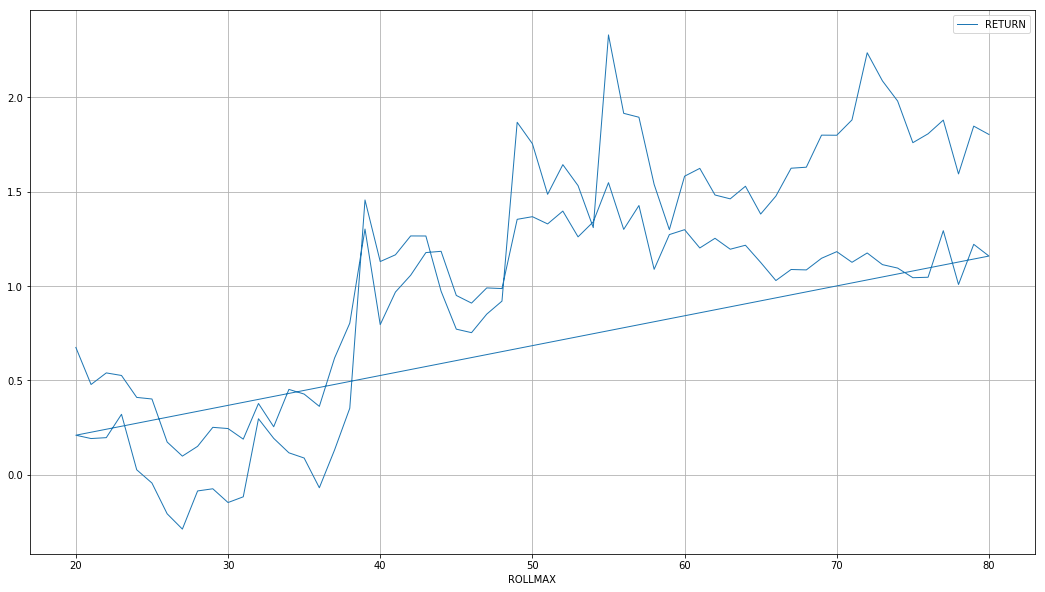

In [22]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
plt.rcParams['figure.figsize'] = [18, 10]

# df = pd.read_csv('../database/2018-09-10-00-18-21.csv')
df = score_df.copy()
df.drop(columns=['MA_SHORT', 'MA_LONG', 'X_DAY_RETURN'], inplace=True)
df = df.loc[:, ['TURTLE_POS', 'ROLLMAX', 'RETURN', 'MAXDROPDOWN', 'STOCK', 'ORDER', 'annual_volatility', 'FREECASH_DAY', 'alpha', 'beta']]
# df.set_index(keys='TURTLE_POS', inplace=True)
df.set_index(keys='ROLLMAX', inplace=True)
# df.sort_values(by='RETURN', ascending=False)
# df

# df = df.groupby(by=['TURTLE_POS', 'ROLLMAX']).count()
# df.groupby(by=['ROLLMAX']).count()
# df = df.groupby(by='ROLLMAX').mean()

# df.groupby(by=['TURTLE_POS']).count()
# df = df.groupby(by='TURTLE_POS').mean()

# emp.annual_volatility(benchmark, period='daily')
# emp.annual_volatility(benchmark[:250], period='daily')

# df
ax = df.plot(kind='line', y=['RETURN'], label='RETURN', linewidth=1, grid=True)
# ax = df.plot(kind='line', y=['annual_volatility'], secondary_y=True, linewidth=1, grid=True, ax=ax)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.bar(left='ROLLMAX', height='TURTLE_POS', zs='RETURN', zdir='TURTLE_POS', alpha=0.8)
# ax.bar(left=df['ROLLMAX'], height=df['TURTLE_POS'], zs=df['RETURN'], zdir=df['TURTLE_POS'], alpha=0.8)

# show_df[start_date:].head(1).open
# show_df.tail(1).open
# (3530.03 - 2323.43) / 2323.43

<Container object of 61 artists>

<Container object of 61 artists>

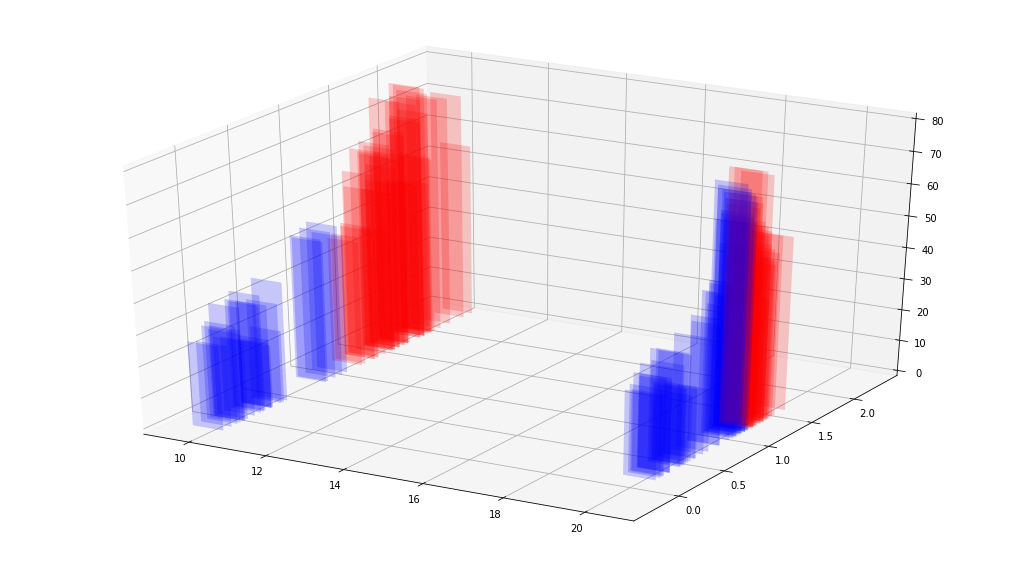

In [24]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [18, 10]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# df = pd.read_csv('../database/ALL.csv')
df = pd.read_csv('../database/2014-2018.csv')
X = df['TURTLE_POS']
Y = df['ROLLMAX']
Z = df['RETURN']
md = Z.median()
# ax.scatter(X, Y, Z, c='r', marker='o')
# ax.bar(X, Y, zs=Z, zdir='y', color='r', alpha=0.2)

df_d = df.loc[df['RETURN'] >= md]
X = df_d['TURTLE_POS']
Y = df_d['ROLLMAX']
Z = df_d['RETURN']
# ax.scatter(X, Y, Z, c='r', marker='o')
ax.bar(X, Y, zs=Z, zdir='y', color='r', alpha=0.2)

df_d = df.loc[df['RETURN'] < md]
X = df_d['TURTLE_POS']
Y = df_d['ROLLMAX']
Z = df_d['RETURN']
# ax.scatter(X, Y, Z, c='b', marker='^')
ax.bar(X, Y, zs=Z, zdir='y', color='b', alpha=0.2)

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# ax.set_yticks(Y)